In [2]:
import xarray as xr
import dask
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import gsw
import pickle
import pandas as pd
import itertools
import seaborn as sns
sns.set('paper')

colors =itertools.cycle(plt.get_cmap('plasma')(np.linspace(0.2,0.9, 3)))
colorA=next(colors)
colorC=next(colors)
colorB=next(colors)
#import basemap
#fig sizes
Wf=(190/25.4)
Hf=(230/25.4)
Wf4=(95/25.4)
Hf4=(115/25.4)

color1='#00CD6C'#green
color2='#AF58BA'#purple
color3='#FFC61E' #yello
color4='#009ADE' #blue
color5='#F28522' #orange
color6='#A0B1BA' #gray
color7='#A6761D'#brown
color8='#FF1F5B' #red

In [3]:
cluster_data_path = '/home/amh001/space_fs7/DATA/NEP36-CanOE/From_Andrew/'
#cluster_data_path = './'
#cluster_2_ds = xr.open_mfdataset(f'{cluster_data_path}/processed/daily/by_year/by_cluster/n_clusters_6/*canyons.nc')
#shallows_ds = xr.open_mfdataset(f'{cluster_data_path}/processed/daily/by_year/by_cluster/n_clusters_6/*shallows.nc')

#cluster_files=sorted(glob.glob(f'{cluster_data_path}/processed/daily/by_year/by_cluster/n_clusters_6/cluster_{i}*.nc'))
clusters_ds=[]
for ii in range(6):
    
    cluster_files = sorted(glob.glob(f'{cluster_data_path}/processed/daily/by_year/by_cluster/n_clusters_6/cluster_{ii}*.nc')) 
    #print(cluster_files    )
    cluster_ds =xr.open_mfdataset(cluster_files, chunks={'time':439}, engine='h5netcdf')
    clusters_ds.append(cluster_ds)

In [4]:
clusters_ds


[<xarray.Dataset>
 Dimensions:      (time: 8766, stacked_y_x: 9308, y: 570, x: 498)
 Coordinates:
   * time         (time) datetime64[ns] 1996-01-01T12:00:00 ... 2019-12-31T12:...
     nav_lon      (stacked_y_x) float32 dask.array<chunksize=(9308,), meta=np.ndarray>
     nav_lat      (stacked_y_x) float32 dask.array<chunksize=(9308,), meta=np.ndarray>
     deptht       float32 0.5075
   * y            (y) int64 0 1 2 3 4 5 6 7 8 ... 562 563 564 565 566 567 568 569
   * x            (x) int64 0 1 2 3 4 5 6 7 8 ... 490 491 492 493 494 495 496 497
   * stacked_y_x  (stacked_y_x) int64 10367 10370 10865 ... 264560 264561 264562
 Data variables:
     ALK          (time, stacked_y_x) float32 dask.array<chunksize=(366, 582), meta=np.ndarray>
     AOU          (time, stacked_y_x) float64 dask.array<chunksize=(366, 582), meta=np.ndarray>
     DIC          (time, stacked_y_x) float32 dask.array<chunksize=(366, 582), meta=np.ndarray>
     NO3          (time, stacked_y_x) float32 dask.array<chunks

In [5]:
hist_kwargs = {
    'alpha':1,
    'density':False,
    'bins':20,
    'edgecolor':'None'
}

## plot all of the clusters for the main manuscript
For this I will load in all 

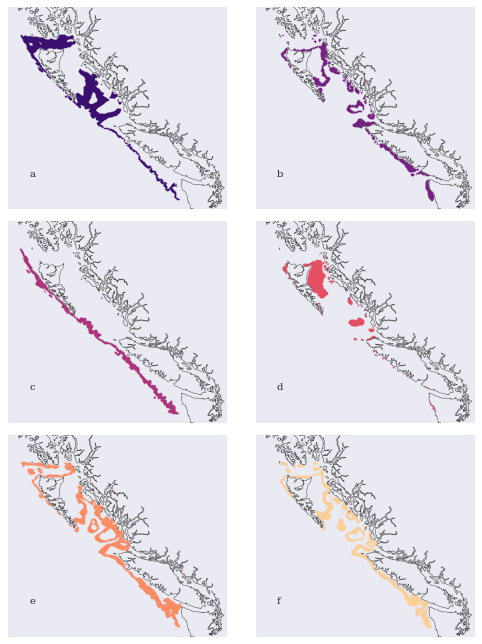

In [6]:
sns.set('paper')

fig=plt.figure(figsize=(Wf,Hf))
################
colors =itertools.cycle(plt.get_cmap('magma')(np.linspace(0.2,0.9, 6)))
sns.set_style('darkgrid')
subpanel = ['a','b','c','d', 'e', 'f', 'g','h','i','j']
#subpanel = ['1','2','3', '4', '5','6']

plt.rcParams["font.family"] = "Serif"
#colors=[colorA,colorB]
p=1
var='T'
at=0.1
bt=.2
#ax = fig.add_subplot(2,2,p)
for ii in np.arange(6):
    if ii==0:
        p=1
    else:
        p=3
    cluster_id = ii#plot_clusters[ii]
    nlat=clusters_ds[cluster_id][var][0,:].nav_lat.values
    nlon=clusters_ds[cluster_id][var][0,:].nav_lon.values
    ax = fig.add_subplot(3,2,ii+1, projection=ccrs.Miller())
    #ax.set_global()

    ax.add_feature(cfeature.COASTLINE, edgecolor='0.3', linewidth=0.5)
    #ax.add_feature(cfeature.BORDERS, edgecolor="0.2")
    #ax.gridlines()

    plt.scatter(x=nlon, y=nlat,
                color=next(colors),
                s=.5,
                alpha=0.5,
                transform=ccrs.PlateCarree()) ## Important

    lat1=56;lat2=47;lon1=-135;lon2=-122
    ax.set_extent([ lon1, lon2, lat1,lat2], crs=ccrs.PlateCarree())
    ax.text(at, bt, subpanel[ii], transform=ax.transAxes,  va='top', fontweight='normal',zorder=1000)
#plt.subplots_adjust(wspace=-0.1)
plt.tight_layout()
plt.savefig('../Figures/clusters.png', format='png', bbox_inches='tight',transparent=False,dpi=500)

In [7]:
plot_clusters = [3, 0]
cluster_names = {3:'Shallows', 0:'Canyons'}
cluster_color = {3:colorA, 0:colorB}

In [8]:
def getRHO(T,S,nlon,nlat,D):
    P=gsw.p_from_z(-D,nlat)
    SA=gsw.SA_from_SP(S, P, nlon,nlat)
    rho=gsw.rho(SA,T,P)-1000
    return rho

In [9]:
for cluster_ds in clusters_ds:
    cluster_ds['ALK_norm'] = 32.5*cluster_ds['ALK']/cluster_ds['S']
    cluster_ds['DIC_norm'] = 32.5*cluster_ds['DIC']/cluster_ds['S']
    D=cluster_ds.depths
    T=cluster_ds.T
    S=cluster_ds.S
    nlat=cluster_ds[var][0,:].nav_lat
    nlon=cluster_ds[var][0,:].nav_lon
    cluster_ds['sigma_0']=getRHO(T,S,nlon,nlat,D)

In [10]:
# Plot timeseries of all the relevant variables

timeseries_vars = [
    'O2',
    'OmegaA',
    'T',
    # 'ALK_norm',
    # 'DIC_norm',
    # 'ALK',
    # 'DIC',
]


long_names = dict(
    O2=r"$[\mathrm{O}_2]$",
    OmegaA="$\Omega_A$",
    T="T",
    ALK_norm="nAlk",
    DIC_norm="nDIC",
     ALK="Alkalinity",
     DIC="DIC",
    S="",
        sigma_0=r"$\sigma_\theta$",
)

units = dict(
    O2="mmol m$^{-3}$",
    OmegaA="(non-dimensional)",
    T="$^\circ$C",
    S="",    
     ALK_norm="mmol m$^{-3}$",
     DIC_norm="mmol m$^{-3}$",
     ALK="mmol m$^{-3}$",
     DIC="mmol m$^{-3}$",
         sigma_0="kg m$^{-3}$"

)

## plotting the cluster over the bathymetry to see how they compare

In [11]:
from netCDF4 import Dataset, num2date

namdepth='/home/amh001/space_fs7/DATA/NEP36-I/HINDCAST/inputs_714x1020/Bathymetry_NEP36_GLORYS12v1OBC_10.nc'
ncT= Dataset(namdepth,'r')
bat = ncT.variables['Bathymetry'][:] #(t,z,y.x)
nav_lon = ncT.variables['nav_lon'][:][:] 
nav_lat = ncT.variables['nav_lat'][:][:]


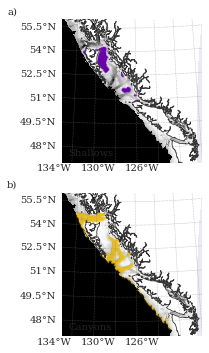

In [12]:

#sns.set_style('whitegrid')
#fig, axs = plt.subplots(3, 1, sharex=True,figsize=(Wf,Hf))
fig=plt.figure(figsize=(Wf,Hf))
################
subpanel = ['a)','b)','d)','e)', 'f)', 'c)']
#plt.rcParams["font.family"] = "Serif"
colors=[colorA,colorB]
p=1
at=-0.28
bt=1.08
at2=0.05
bt2=.1
for ii in np.arange(2):
    if ii==0:
        p=1
    else:
        p=3
    cluster_id = plot_clusters[ii]
    nlat=clusters_ds[cluster_id][var][0,:].nav_lat.values
    nlon=clusters_ds[cluster_id][var][0,:].nav_lon.values
    ax = fig.add_subplot(3,2,p, projection=ccrs.AlbersEqualArea(central_latitude=51, central_longitude=-129.5))
    #ax.set_global()

    ax.add_feature(cfeature.COASTLINE, edgecolor="0.2")
    #ax.add_feature(cfeature.BORDERS, edgecolor="0.2")
    #ax.gridlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.top_labels = False
    gl.right_labels = False
    cs3 =ax.pcolormesh(nav_lon,nav_lat,bat,cmap='Greys',vmin=0, vmax=500, transform=ccrs.PlateCarree() )

    plt.scatter(x=nlon, y=nlat,
                color=colors[ii],
                s=1,
                alpha=0.05,
                transform=ccrs.PlateCarree()) ## Important

    #plt.yticks(rotation='vertical')
    lat1=56;lat2=47;lon1=-135;lon2=-122
    ax.set_extent([ lon1, lon2, lat1,lat2], crs=ccrs.PlateCarree())
    ax.text(at2, bt2, cluster_names[cluster_id], transform=ax.transAxes,  va='top', fontweight='normal',zorder=1000)
    ax.text(at-0.1, bt, subpanel[ii], transform=ax.transAxes,  va='top', fontweight='normal',zorder=1000)
    gl.xlabel_style = {'size': 10, 'rotation':0}
    gl.ylabel_style = { 'size':10,'rotation':0}
    #ax.text(0.5, 1.1, cluster_name[cluster_id], transform=ax.transAxes,  va='top', fontweight='normal',zorder=1000)


3 depths 28.902779191472252 69.02298736572266
0 depths 262.8805803045675 947.4501342773438


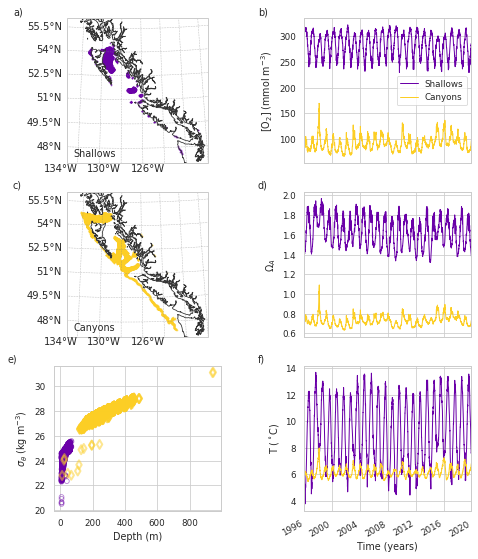

In [14]:
sns.set('paper')

sns.set_style('whitegrid')
#fig, axs = plt.subplots(3, 1, sharex=True,figsize=(Wf,Hf))
fig=plt.figure(figsize=(Wf,Hf))
################
subpanel = ['a)','c)','b)','d)', 'f)', 'e)']
#plt.rcParams["font.family"] = "Serif"
colors=[colorA,colorB]
p=1
at=-0.28
bt=1.08
at2=0.05
bt2=.1
al=0.5
#ax = fig.add_subplot(2,2,p)
for ii in np.arange(2):
    if ii==0:
        p=1
    else:
        p=3
    cluster_id = plot_clusters[ii]
    nlat=clusters_ds[cluster_id][var][0,:].nav_lat.values
    nlon=clusters_ds[cluster_id][var][0,:].nav_lon.values
    ax = fig.add_subplot(3,2,p, projection=ccrs.AlbersEqualArea(central_latitude=51, central_longitude=-129.5))
    #ax.set_global()

    ax.add_feature(cfeature.COASTLINE, edgecolor="0.2")
    #ax.add_feature(cfeature.BORDERS, edgecolor="0.2")
    #ax.gridlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.top_labels = False
    gl.right_labels = False
    plt.scatter(x=nlon, y=nlat,
                color=colors[ii],
                s=1,
                alpha=0.5,
                transform=ccrs.PlateCarree()) ## Important

    #plt.yticks(rotation='vertical')
    lat1=56;lat2=47;lon1=-135;lon2=-122
    ax.set_extent([ lon1, lon2, lat1,lat2], crs=ccrs.PlateCarree())
    ax.text(at2, bt2, cluster_names[cluster_id], transform=ax.transAxes,  va='top', fontweight='normal',zorder=1000)
    ax.text(at-0.1, bt, subpanel[ii], transform=ax.transAxes,  va='top', fontweight='normal',zorder=1000)
    gl.xlabel_style = {'size': 10, 'rotation':0}
    gl.ylabel_style = { 'size':10,'rotation':0}
    #ax.text(0.5, 1.1, cluster_name[cluster_id], transform=ax.transAxes,  va='top', fontweight='normal',zorder=1000)

    #plt.title(cluster_name[cluster_id])
###############

cluster_id=plot_clusters[0]
print(cluster_id, 'depths',  clusters_ds[cluster_id].depths.mean().values,  clusters_ds[cluster_id].depths.max().values)
cluster_id=plot_clusters[1]
print(cluster_id, 'depths',  clusters_ds[cluster_id].depths.mean().values,  clusters_ds[cluster_id].depths.max().values)

for i, var in enumerate(timeseries_vars):
    #print(i)
    if i==0:
        p=2
    if i==1:
        p=4
    if i==2:
        p=6
    ax = fig.add_subplot(3,2,p)

    cluster_id = plot_clusters[0]
    clusters_ds[cluster_id][var].mean('stacked_y_x').plot(label=cluster_names[cluster_id], ax=ax, linewidth=1,color=colorA)
   # print('Mean values for var', var,  clusters_ds[cluster_id][var].mean('stacked_y_x').mean().compute())
    cluster_id = plot_clusters[1]
    clusters_ds[cluster_id][var].mean('stacked_y_x').plot(label=cluster_names[cluster_id], ax=ax, linewidth=1, color=colorB,zorder=2)

    if i != 2:
        ax.set_xlabel('')
        ax.set_xticklabels([])
    if i == 0:
        ax.legend()
   
    if var=='OmegaA':
        ax.set_ylabel(f"{long_names[var]}")
    else:
        ax.set_ylabel(f"{long_names[var]} ({units[var]})")
    ax.grid('on')
    #ax.set_title(f'({subpanel[i]})')
    ax.text(at, bt, subpanel[i+2], transform=ax.transAxes,  va='top', fontweight='normal',zorder=1000)

    plt.axis('tight')
    X=ax.get_xticks()
    #print(X)
    plt.title('')
    plt.xlim([X[1], X[-2]])
plt.xlabel('Time (years)')
p=5
ax = fig.add_subplot(3,2,p)

cluster_id = plot_clusters[0]
D=clusters_ds[cluster_id].depths.mean('time').values.flatten()
rho=clusters_ds[cluster_id].sigma_0.mean('time').values.flatten()
#plt.scatter(D0,rho0, color=cluster_color[cluster_id],marker='o', alpha=al)
plt.scatter(D,rho, edgecolors=cluster_color[cluster_id], color='None',marker='o', alpha=al)

cluster_id = plot_clusters[1]
D=clusters_ds[cluster_id].depths.mean('time').values.flatten()
rho=clusters_ds[cluster_id].sigma_0.mean('time').values.flatten()
plt.scatter(D,rho, s=40,edgecolors=cluster_color[cluster_id], color='None',marker='d', alpha=al,linewidth=2)

plt.xlabel('Depth (m)')
var='sigma_0'
ax.set_ylabel(f"{long_names[var]} ({units[var]})")
ax.text(at, bt, subpanel[i+3], transform=ax.transAxes,  va='top', fontweight='normal',zorder=1000)

plt.subplots_adjust(wspace=0.5)
plt.savefig('../Figures/cluster_timeseries.png', format='png', bbox_inches='tight',transparent=False,dpi=500)      

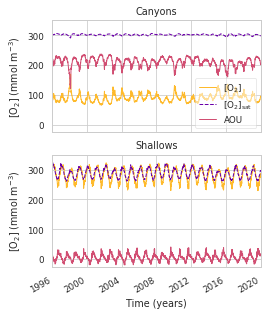

In [40]:
colors =itertools.cycle(plt.get_cmap('plasma')(np.linspace(0.2,0.85, 3)))
colorA=next(colors)
colorC=next(colors)
colorB=next(colors)
def plot_O2(cluster_id):
    clusters_ds[cluster_id][var].mean('stacked_y_x').plot(label='$[\mathrm{O}_2]$', ax=ax, linewidth=1,color=colorB)
    (clusters_ds[cluster_id]['AOU'].mean('stacked_y_x')+clusters_ds[cluster_id][var].mean('stacked_y_x')).plot(label='$[\mathrm{O}_2]_{\mathrm{sat}}$', linestyle='--', ax=ax, linewidth=1,color=colorA)
    clusters_ds[cluster_id]['AOU'].mean('stacked_y_x').plot(label='AOU', ax=ax, linewidth=1,color=colorC)
    ax.set_ylabel(f"{long_names[var]} ({units[var]})")
    plt.title(cluster_names[cluster_id])
    plt.axis('tight')
    X=ax.get_xticks()
    plt.grid('on')
    plt.xlim([X[1], X[-2]])
    plt.ylim([-25, 350])

fig=plt.figure(figsize=(Wf4,Hf4))
ax = fig.add_subplot(2,1,1)

var='O2'
cluster_id = plot_clusters[0]
plot_O2(cluster_id)
plt.legend(framealpha=0.5)
ax.set_xlabel('')
ax.set_xticklabels([])
ax = fig.add_subplot(2,1,2)


cluster_id = plot_clusters[1]
plot_O2(cluster_id)
plt.xlabel('Time (years)')
plt.savefig('../Figures/oxygen_timeseries.png', format='png', bbox_inches='tight',transparent=False,dpi=500)      

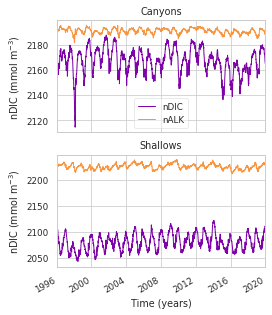

In [41]:
var='DIC_norm'
colors =itertools.cycle(plt.get_cmap('plasma')(np.linspace(0.25,0.75, 3)))
colorA=next(colors)
colorC=next(colors)
colorB=next(colors)
def plot_O2(cluster_id):
    clusters_ds[cluster_id][var].mean('stacked_y_x').plot(label='nDIC', ax=ax, linewidth=1,color=colorA)
    clusters_ds[cluster_id]['ALK_norm'].mean('stacked_y_x').plot(label='nALK', ax=ax, linewidth=1,color=colorB)

    #(clusters_ds[cluster_id]['AOU'].mean('stacked_y_x')+clusters_ds[cluster_id][var].mean('stacked_y_x')).plot(label='$[\mathrm{O}_2]_{\mathrm{sat}}$', linestyle='--', ax=ax, linewidth=1,color=colorA)
    #clusters_ds[cluster_id]['AOU'].mean('stacked_y_x').plot(label='AOU', ax=ax, linewidth=1,color=colorC)
    ax.set_ylabel(f"{long_names[var]} ({units[var]})")
    plt.title(cluster_names[cluster_id])
    plt.axis('tight')
    X=ax.get_xticks()
    plt.grid('on')
    plt.xlim([X[1], X[-2]])
   # plt.ylim([-25, 350])

fig=plt.figure(figsize=(Wf4,Hf4))
ax = fig.add_subplot(2,1,1)


cluster_id = plot_clusters[0]
plot_O2(cluster_id)
plt.legend(framealpha=0.5)
ax.set_xlabel('')
ax.set_xticklabels([])
ax = fig.add_subplot(2,1,2)


cluster_id = plot_clusters[1]
plot_O2(cluster_id)
plt.xlabel('Time (years)')
#plt.ylabel('salinity norm')
plt.savefig('../Figures/nDIC_timeseries.png', format='png', bbox_inches='tight',transparent=False,dpi=500)      

In [42]:
#clusters_ds[0]

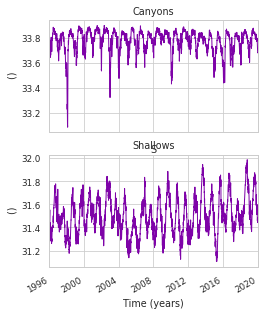

In [43]:
var='S'
colors =itertools.cycle(plt.get_cmap('plasma')(np.linspace(0.25,0.75, 3)))
colorA=next(colors)
colorC=next(colors)
colorB=next(colors)
def plot_O2(cluster_id):
    clusters_ds[cluster_id][var].mean('stacked_y_x').plot(label='nDIC', ax=ax, linewidth=1,color=colorA)
    #clusters_ds[cluster_id]['ALK_norm'].mean('stacked_y_x').plot(label='nALK', ax=ax, linewidth=1,color=colorB)

    #(clusters_ds[cluster_id]['AOU'].mean('stacked_y_x')+clusters_ds[cluster_id][var].mean('stacked_y_x')).plot(label='$[\mathrm{O}_2]_{\mathrm{sat}}$', linestyle='--', ax=ax, linewidth=1,color=colorA)
    #clusters_ds[cluster_id]['AOU'].mean('stacked_y_x').plot(label='AOU', ax=ax, linewidth=1,color=colorC)
    ax.set_ylabel(f"{long_names[var]} ({units[var]})")
    plt.title(cluster_names[cluster_id])
    plt.axis('tight')
    X=ax.get_xticks()
    plt.grid('on')
    plt.xlim([X[1], X[-2]])
   # plt.ylim([-25, 350])

fig=plt.figure(figsize=(Wf4,Hf4))
ax = fig.add_subplot(2,1,1)


cluster_id = plot_clusters[0]
plot_O2(cluster_id)
#plt.legend(framealpha=0.5)
ax.set_xlabel('S')
ax.set_xticklabels([])
ax = fig.add_subplot(2,1,2)


cluster_id = plot_clusters[1]
plot_O2(cluster_id)
plt.xlabel('Time (years)')
#plt.ylabel('salinity norm')
plt.savefig('../Figures/S_timeseries.png', format='png', bbox_inches='tight',transparent=False,dpi=500)      

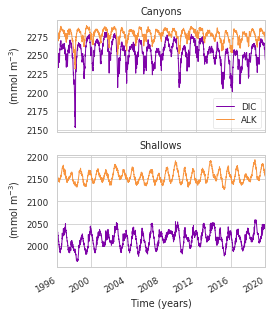

In [44]:
var='DIC'
colors =itertools.cycle(plt.get_cmap('plasma')(np.linspace(0.25,0.75, 3)))
colorA=next(colors)
colorC=next(colors)
colorB=next(colors)
def plot_O2(cluster_id):
    clusters_ds[cluster_id][var].mean('stacked_y_x').plot(label='DIC', ax=ax, linewidth=1,color=colorA)
    clusters_ds[cluster_id]['ALK'].mean('stacked_y_x').plot(label='ALK', ax=ax, linewidth=1,color=colorB)

    #(clusters_ds[cluster_id]['AOU'].mean('stacked_y_x')+clusters_ds[cluster_id][var].mean('stacked_y_x')).plot(label='$[\mathrm{O}_2]_{\mathrm{sat}}$', linestyle='--', ax=ax, linewidth=1,color=colorA)
    #clusters_ds[cluster_id]['AOU'].mean('stacked_y_x').plot(label='AOU', ax=ax, linewidth=1,color=colorC)
    ax.set_ylabel(f" ({units[var]})")
    plt.title(cluster_names[cluster_id])
    plt.axis('tight')
    X=ax.get_xticks()
    plt.grid('on')
    plt.xlim([X[1], X[-2]])
   # plt.ylim([-25, 350])

fig=plt.figure(figsize=(Wf4,Hf4))
ax = fig.add_subplot(2,1,1)


cluster_id = plot_clusters[0]
plot_O2(cluster_id)
plt.legend(framealpha=0.5)
ax.set_xlabel('')
ax.set_xticklabels([])
ax = fig.add_subplot(2,1,2)


cluster_id = plot_clusters[1]
plot_O2(cluster_id)
plt.xlabel('Time (years)')
#plt.ylabel('salinity norm')
plt.savefig('../Figures/DIC_timeseries.png', format='png', bbox_inches='tight',transparent=False,dpi=500) 

In [45]:
def deseason(monthly_des, seas):

    num=12
    #print(monthly_des.shape, seas.shape)
    ii0=0
    ii=12
    print(len(monthly_des))
    while ii <=len(monthly_des):  
        #print(ii0, ii)
        monthly_des[ii0:ii]=monthly_des[ii0:ii]-seas
        ii0=ii
        ii=ii+12
    
    #monthly_des[-1]=monthly_des[-2]#-seas['HeatC'].values[0]
    return monthly_des

let's try remaking the plot with the seasonal cylce removed

In [46]:
def get_deseasoned_plot(cluster_ds, var, color, label, linestyle):
    cluster=cluster_ds.sel(time=slice('1996-01-01T12:00:00', '2019-12-31T12:00:00'))
    ds_months = cluster.groupby('time.month').mean()    
    monthly=cluster.resample(time='1MS').mean(dim='time')
    X=deseason(monthly[var].values,ds_months[var].values)
    X0=np.mean(X, axis=1)
    plt.plot(monthly.time.values, X0, color=color, label=label, linestyle=linestyle)

288
288
288
288
288
288


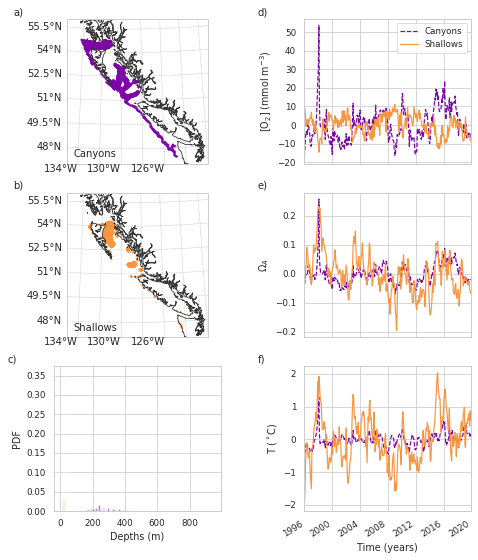

In [47]:
fig=plt.figure(figsize=(Wf,Hf))
p=1
at=-0.28
bt=1.08
at2=0.05
bt2=.1
colorAB=[colorA,colorB]

#ax = fig.add_subplot(2,2,p)
for ii in np.arange(2):
    if ii==0:
        p=1
    else:
        p=3
    cluster_id = plot_clusters[ii]
    nlat=clusters_ds[cluster_id][var][0,:].nav_lat.values
    nlon=clusters_ds[cluster_id][var][0,:].nav_lon.values
    ax = fig.add_subplot(3,2,p, projection=ccrs.AlbersEqualArea(central_latitude=51, central_longitude=-129.5))
    #ax.set_global()

    ax.add_feature(cfeature.COASTLINE, edgecolor="0.2")
    #ax.add_feature(cfeature.BORDERS, edgecolor="0.2")
    #ax.gridlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.top_labels = False
    gl.right_labels = False
    plt.scatter(x=nlon, y=nlat,
                color=colorAB[ii],
                s=1,
                alpha=0.5,
                transform=ccrs.PlateCarree()) ## Important

    #plt.yticks(rotation='vertical')
    lat1=56;lat2=47;lon1=-135;lon2=-122
    ax.set_extent([ lon1, lon2, lat1,lat2], crs=ccrs.PlateCarree())
    ax.text(at2, bt2, cluster_names[cluster_id], transform=ax.transAxes,  va='top', fontweight='normal',zorder=1000)
    ax.text(at-0.1, bt, subpanel[ii], transform=ax.transAxes,  va='top', fontweight='normal',zorder=1000)
    gl.xlabel_style = {'size': 10, 'rotation':0}
    gl.ylabel_style = { 'size':10,'rotation':0}
    #ax.text(0.5, 1.1, cluster_name[cluster_id], transform=ax.transAxes,  va='top', fontweight='normal',zorder=1000)

for i, var in enumerate(timeseries_vars):
    #print(i)
    if i==0:
        p=2
    if i==1:
        p=4
    if i==2:
        p=6
    ax = fig.add_subplot(3,2,p)

    cluster_id = plot_clusters[0]
    get_deseasoned_plot(clusters_ds[cluster_id], var, colorA, label=cluster_names[cluster_id], linestyle='--')
        
   # clusters_ds[cluster_id][var].mean('stacked_y_x').plot(label=cluster_names[cluster_id], ax=ax, linewidth=1,color=colorA,linestyle='--')
   # print('Mean values for var', var,  clusters_ds[cluster_id][var].mean('stacked_y_x').mean().compute())
    cluster_id = plot_clusters[1]
    get_deseasoned_plot(clusters_ds[cluster_id], var, colorB, label=cluster_names[cluster_id], linestyle='-')

    #clusters_ds[cluster_id][var].mean('stacked_y_x').plot(label=cluster_names[cluster_id], ax=ax, linewidth=1, color=colorB,zorder=2)
    #print('Mean values for var', var,  clusters_ds[cluster_id][var].mean('stacked_y_x').mean().compute())
    #ax.set_ylabel(f"{long_names[var]}\n({units[var]})")
    if i != 2:
        ax.set_xlabel('')
        ax.set_xticklabels([])
    if i == 0:
        ax.legend()
    if var=='OmegaA':
        ax.set_ylabel(f"{long_names[var]}")
    else:
        ax.set_ylabel(f"{long_names[var]} ({units[var]})")
    ax.grid('on')
    #ax.set_title(f'({subpanel[i]})')
    ax.text(at, bt, subpanel[i+2], transform=ax.transAxes,  va='top', fontweight='normal',zorder=1000)

    plt.axis('tight')
    X=ax.get_xticks()
    #print(X)
    plt.title('')
    plt.xlim([X[1], X[-2]])
for label in ax.get_xticklabels():
    label.set_rotation(32)
    label.set_horizontalalignment("right")
plt.xlabel('Time (years)')
p=5
ax = fig.add_subplot(3,2,p)
#for cluster_ds in clusters_ds:
cluster_id = plot_clusters[0]
D=clusters_ds[cluster_id].depths.values
#plt.hist(D.flatten(),label='Shallows',density=True,  color=colorA)
plt.hist(D.flatten(),label='Shallows', **hist_kwargs, color=colorA)

cluster_id = plot_clusters[1]
D=clusters_ds[cluster_id].depths.values
plt.hist(D.flatten(),label='Canyons',  **hist_kwargs,color=colorB)
#plt.hist(D.flatten(),label='Canyons',density=True,  color=colorB)

plt.xlabel('Depths (m)')
plt.ylabel('PDF')
ax.text(at, bt, subpanel[i+3], transform=ax.transAxes,  va='top', fontweight='normal',zorder=1000)

plt.subplots_adjust(wspace=0.5)
plt.savefig('../Figures/cluster_timeseries_deseas_DIC.png', format='png', bbox_inches='tight',transparent=False,dpi=500)  

In [15]:
# Split by upwelling season
downwelling_months = [10, 11, 12, 1, 2, 3]
upwelling_months   = [4, 5, 6, 7, 8, 9]
timeseries_vars = ['O2','OmegaA','T']
hist_kwargs = {
    'alpha':0.7,
    'density':True,
    'bins':200,
    'edgecolor':'None'
}

def filter_by_season_and_values(ds,month_range):       
    ds_out = ds.where(ds['time.month'].isin(month_range),drop=True)
    return ds_out

0
3


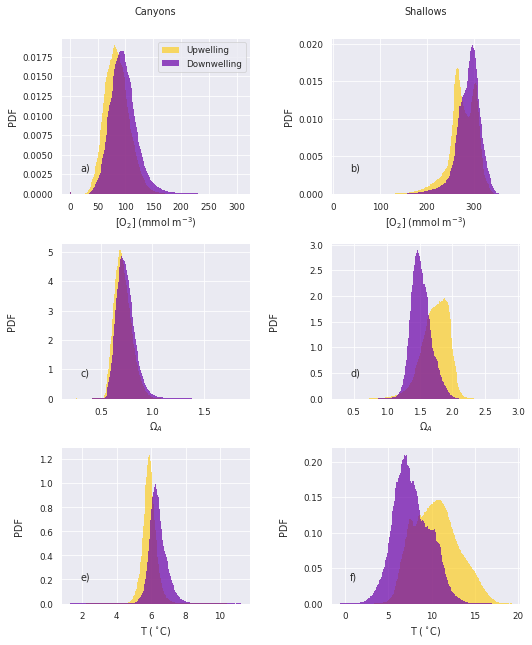

In [32]:
#font = {'family:':'sans serif',
 #       'weight' : 'bold',
  #      'size'   : 12}

#matplotlib.rc('font', **font)
sns.set('paper')

downwelling = {}
upwelling = {}
subpanel = ['a)','c)','e)','b)', 'd)', 'f)']

#sns.set_style('ticks')
plt.figure(figsize=(Wf,Hf))
att=0.5
btt=1.2
at=0.1
bt=.2
for cluster_label, cluster_ds in enumerate(clusters_ds):
    if cluster_label in plot_clusters:
        print(cluster_label)
        ds_months = cluster_ds.groupby('time.month')    
        # For every dataset separate data in upwelling and downwelling months
        upwelling_ds = filter_by_season_and_values(cluster_ds, upwelling_months)
        downwelling_ds = filter_by_season_and_values(cluster_ds, downwelling_months)
        downwelling[cluster_label] = downwelling_ds.copy()
        upwelling[cluster_label] = upwelling_ds.copy()
        if cluster_label==3:
            clust=3
        else:
            clust=0
        for idx, var in enumerate(timeseries_vars):  
            fig0=idx+clust+1
            if fig0==2:
                fig=3
            elif fig0==3:
                fig=5
            elif fig0==4:
                fig=2
            elif fig0==5:
                fig=4
            else:
                fig=fig0
            
            #print(idx,fig0,fig)
            ax=plt.subplot(3,2,fig)
            plt.hist(upwelling_ds[var].to_numpy().flatten(),label='Upwelling', **hist_kwargs, color=colorB)
            plt.hist(downwelling_ds[var].to_numpy().flatten(),label='Downwelling', **hist_kwargs, color=colorA)
            if fig ==3 or fig==4:
                ax.set_ylabel('PDF', labelpad=30)
            elif fig ==5 or fig==6:
                ax.set_ylabel('PDF', labelpad=15)
            else:
                ax.set_ylabel('PDF')
            name=cluster_names[cluster_label]

            if fig==1 or fig==2:
                #plt.ylim([0,0.021])
                ax.text(att, btt, name, transform=ax.transAxes,  va='top',ha='center', fontweight='normal',zorder=1000)

           # elif fig==3 or fig==4:
            #    plt.ylim([0,5])
            #elif fig==5 or fig==6:
            #    plt.ylim([0,1.1])


            if var=='OmegaA':
                ax.set_xlabel(f"{long_names[var]}")
            else:
                ax.set_xlabel(f"{long_names[var]} ({units[var]})")
            if idx+clust == 0:
                #plt.title(cluster_names[cluster_label])
                plt.legend()
            ax.text(at, bt, subpanel[idx+clust], transform=ax.transAxes,  va='top', fontweight='normal',zorder=1000)
    plt.tight_layout(w_pad=2)
    #plt.subplots_adjust(wspace=0.4)
    plt.savefig('../Figures/distributions.png',bbox_inches='tight',transparent=False,dpi=500)#'+str(cluster_names[cluster_label])+'.jpg', format='jpg', bbox_inches='tight',transparent=False,dpi=500)      

In [50]:
# plt.style.use(['seaborn-notebook'])

In [51]:
linecolors = dict(
    pdf = 'k',
    cdf = 'b'
)
linestyles = dict(
    Upwelling = '-',
    Downwelling = '--'
)

def plot_cdf_pdf(da_upwelling, da_downwelling, nbins=100):
    da_list = ((da_upwelling, 'Upwelling'), (da_downwelling, 'Downwelling'))
    for da, label in da_list:
        data = da.to_numpy().flatten()
        hist, edges = np.histogram(data, bins=nbins, density=True)
        cdf = integrate.cumtrapz(hist,edges[1:])
        
        plt.plot(edges[1:], hist, color=linecolors['pdf'], linewidth=1, linestyle = linestyles[label], label=f'{label}-PDF')
        plt.plot(edges[2:], cdf, color=linecolors['cdf'], linewidth=1, linestyle = linestyles[label], label=f'{label}-CDF')

In [52]:
linecolors = dict(
    pdf = 'k',
    cdf = 'b'
)
linestyles = dict(
    Upwelling = '-',
    Downwelling = '--'
)

def plot_cdf_pdf(da_upwelling, da_downwelling, nbins=100):
    da_list = ((da_upwelling, 'Upwelling'), (da_downwelling, 'Downwelling'))
    for da, label in da_list:
        data = da.to_numpy().flatten()
        hist, edges = np.histogram(data, bins=nbins, density=True)
        cdf = integrate.cumtrapz(hist,edges[1:])
        
        plt.plot(edges[2:], cdf, color=linecolors['cdf'], linewidth=1, linestyle = linestyles[label], label=f'{label}-CDF')

In [53]:
def PickleforPlots(y):
    x=y.time

    # make a dataframe with groups separated that are over a day apart
    data = []
    g = 0
    for i in range(len(x)):
        x0 = x[i].values
        #print('xo', x0)
        y0 = y[i].values
        if i < (len(x)-1):
            x1 = x[i+1]
            td = x1 - x0
            #print(td)
            elapsed_days = td/np.timedelta64(1, 'D')
            
            if elapsed_days < 2:
                
                data.append([x0,y0, g])
            else:
                data.append([x0,y0, g])
                g+=1
        else:
            data.append([x0,y0, g])
    
    return pd.DataFrame(data, columns=['x', 'y', 'group'])
def plot_fraction_extreme(ax, ds, thresholds, vars, plot_months, extreme_is_low, label,color):
    frac_extreme = calc_extremes(ds, thresholds, vars)
    frac_extreme = frac_extreme.where(frac_extreme['time.month'].isin(plot_months))
     
    df=PickleforPlots(frac_extreme)
    with open('pickles/'+label +'.pickle', 'wb') as handle:
            pickle.dump(df, handle)

    #ax.scatter(frac_extreme.time, frac_extreme, label=label, s=2, color=color)
    


Cluster label: 0
	O2 Upwelling: 58.9
	O2 Downwelling: 68.6
	OmegaA Upwelling: 0.6
	OmegaA Downwelling: 0.6
	T Upwelling: 6.4
	T Downwelling: 7.1
Cluster label: 3
	O2 Upwelling: 241.3
	O2 Downwelling: 260.1
	OmegaA Upwelling: 1.5
	OmegaA Downwelling: 1.3
	T Upwelling: 14.1
	T Downwelling: 10.7


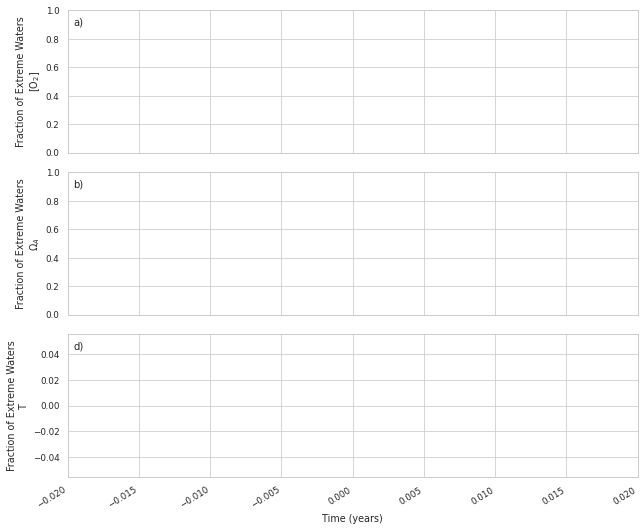

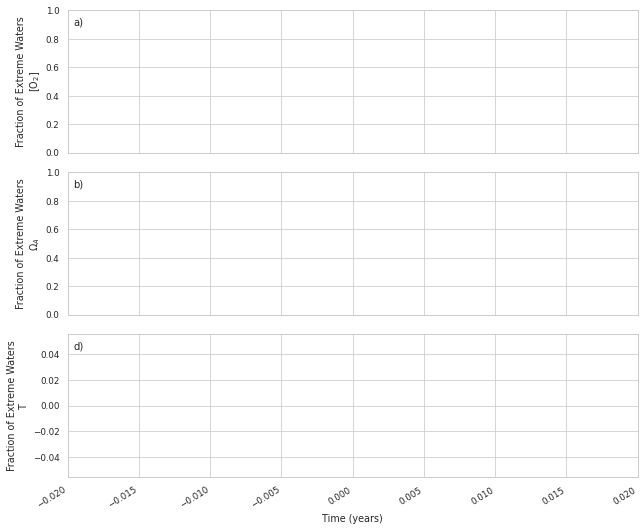

In [54]:
# Calculate extreme thresholds by upwelling/downwelling season and plot timeseries of percentage extremes
downwelling_months = [10, 11, 12, 1, 2, 3]
upwelling_months   = [4, 5, 6, 7, 8, 9]
timeseries_vars = ['O2','OmegaA','T']
hist_kwargs = {
    'alpha':0.5,
    'density':True,
    'bins':100
}

base_percentile = 0.1
percentiles = {
    'O2':base_percentile,
    'OmegaA':base_percentile,
    'T':1-base_percentile
}
at=0.01
bt=0.95
def calculate_threshold(ds, percentile, nbins=1000):
    data = ds.to_numpy().flatten()
    hist, edges = np.histogram(data, bins=nbins, density=True)
    cdf = integrate.cumtrapz(hist,edges[1:])
    return np.interp(percentile, cdf, edges[2:])    

def calc_extremes(ds, thresholds, vars):
    """Calculate which points in the domain exceed multiple thresholds"""
    is_extreme = xr.full_like(ds[vars[0]], True, dtype=bool)
    for var in vars:
        if var == 'T':
            is_extreme=is_extreme & (ds[var] >= thresholds[var])
        else:
            is_extreme=is_extreme & (ds[var] <= thresholds[var])
    npts = len(ds.stacked_y_x)
    frac_extreme = is_extreme.sum('stacked_y_x')/npts
    return frac_extreme


upwelling = {}
downwelling = {}

thresholds = {}

for cluster_label, cluster_ds in enumerate(clusters_ds):    
    if cluster_label in plot_clusters:
        thresholds[cluster_label] = {}
        thresholds[cluster_label]['upwelling'] = {}
        thresholds[cluster_label]['downwelling'] = {}
        ds_months = cluster_ds.groupby('time.month')
        
        # For every dataset separate data in upwelling and downwelling months
        upwelling_ds = filter_by_season_and_values(cluster_ds, upwelling_months)    
        downwelling_ds = filter_by_season_and_values(cluster_ds, downwelling_months)    
    
        upwelling[cluster_label] = upwelling_ds.copy()
        downwelling[cluster_label] = downwelling.copy()
        print(f'Cluster label: {cluster_label}')
                   
        fig, axs = plt.subplots(3, 1, sharex=True, figsize=(Hf,Wf))
        for idx, var in enumerate(timeseries_vars):         
            percentile = percentiles[var]
            upwelling_threshold = calculate_threshold(upwelling_ds[var],percentile)
            downwelling_threshold = calculate_threshold(downwelling_ds[var],percentile)
            thresholds[cluster_label]['upwelling'][var] = upwelling_threshold
            thresholds[cluster_label]['downwelling'][var] = downwelling_threshold
            print(f'\t{var} Upwelling: {upwelling_threshold:.1f}')
            print(f'\t{var} Downwelling: {downwelling_threshold:.1f}')
            plot_fraction_extreme(
                axs[idx],
                upwelling_ds, 
                thresholds[cluster_label]['upwelling'],
                [var],
                upwelling_months,
                percentile == base_percentile,
                f'Upwelling_{cluster_label}_{var}',
                color=color1
            )
            plot_fraction_extreme(
                axs[idx],
                downwelling_ds, 
                thresholds[cluster_label]['downwelling'],
                [var],
                downwelling_months,
                percentile == base_percentile,
                f'Downwelling_{cluster_label}_{var}',
                color=color2
            )

            axs[idx].set_ylabel(f'Fraction of Extreme Waters\n{long_names[var]}')
            if idx==2:
                axs[idx].set_xlabel('Time (years)')
                for label in axs[idx].get_xticklabels():
                    label.set_rotation(32)
                    label.set_horizontalalignment("right")
            plt.axis('tight')
            X=axs[idx].get_xticks()
            plt.xlim([X[1], X[-2]])  
            axs[idx].text(at, bt, subpanel[idx], transform=axs[idx].transAxes,  va='top', fontweight='normal',zorder=1000)


        fig.tight_layout()


see the LinePlots notebook for the line plot instead of scatter

In [55]:
def calc_concurrent_extremes(ds, thresholds, vars):
    is_extreme = xr.full_like(ds[vars[0]], True, dtype=bool)
    for var in vars:
        if var == 'T':
            is_extreme=is_extreme & (ds[var] >= thresholds[var])
        else:
            is_extreme=is_extreme & (ds[var] <= thresholds[var])
        npts = len(ds.stacked_y_x)
        frac_extreme = is_extreme.sum('stacked_y_x')/npts
        return frac_extreme
    
    

Cluster label: 0
Cluster label: 3


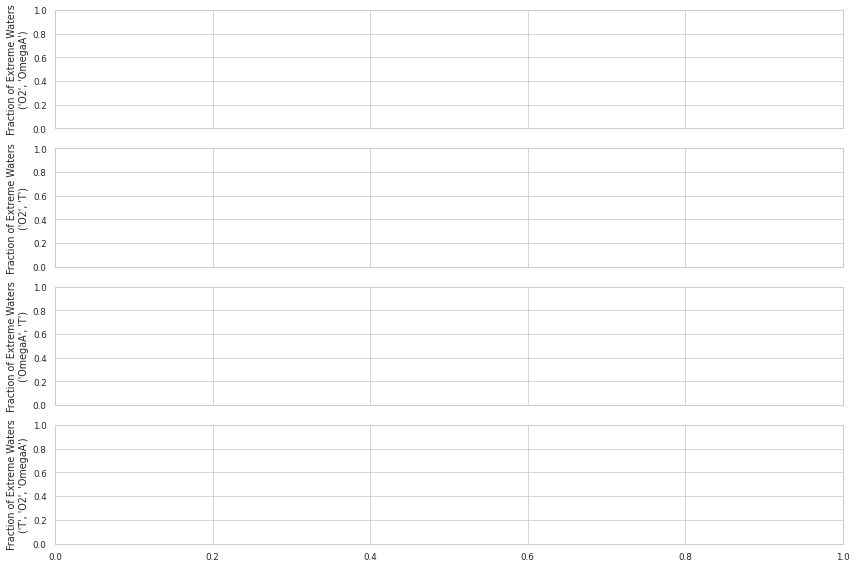

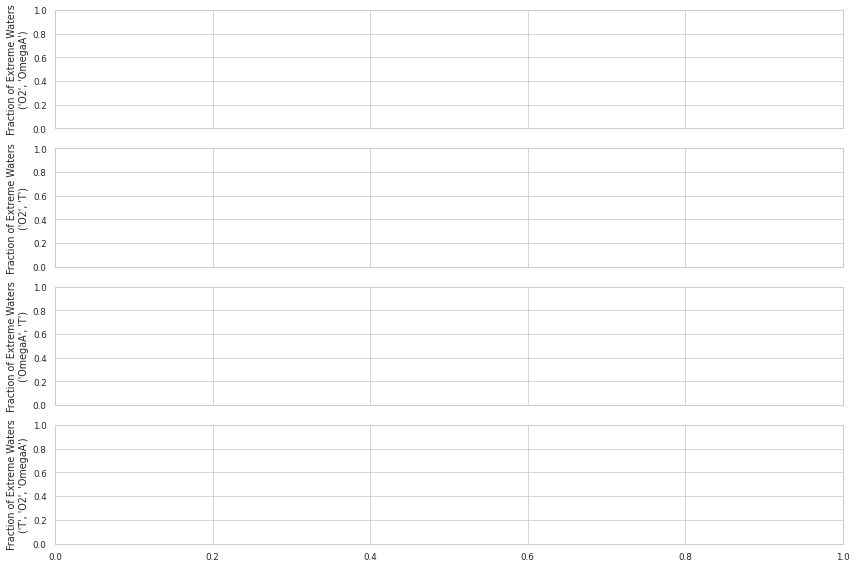

In [56]:
dual_extreme = list(itertools.combinations(timeseries_vars, 2))
dual_extreme += [('T','O2','OmegaA')]

for cluster_label, cluster_ds in enumerate(clusters_ds):    
    if cluster_label in plot_clusters:
        # For every dataset separate data in upwelling and downwelling months
        upwelling_ds = filter_by_season_and_values(cluster_ds, upwelling_months)    
        downwelling_ds = filter_by_season_and_values(cluster_ds, downwelling_months)    
    
        upwelling[cluster_label] = upwelling_ds.copy()
        downwelling[cluster_label] = downwelling.copy()
        print(f'Cluster label: {cluster_label}')

        
        fig, axs = plt.subplots(len(dual_extreme), 1, sharex=True, figsize=(12,8))
        for idx, vars in enumerate(dual_extreme):         
            plot_fraction_extreme(
                axs[idx],
                upwelling_ds, 
                thresholds[cluster_label]['upwelling'],
                vars,
                upwelling_months,
                True,
                 f'Upwelling_{cluster_label}_'+dual_extreme[idx][0]+dual_extreme[idx][1],
                color=color1
            )
            plot_fraction_extreme(
                axs[idx],
                downwelling_ds, 
                thresholds[cluster_label]['downwelling'],
                vars,
                downwelling_months,
                True,
                f'Downwelling_{cluster_label}_'+dual_extreme[idx][0]+dual_extreme[idx][1],
                color=color2
            )
            axs[idx].set_ylabel(f'Fraction of Extreme Waters\n{vars}')
        fig.tight_layout()

In [57]:
for idx, vars in enumerate(dual_extreme):
    print(dual_extreme[idx][0]+dual_extreme[idx][1])
    print(f'Upwelling_{cluster_label}_'+dual_extreme[idx][0]+dual_extreme[idx][1])
    print(vars) 

O2OmegaA
Upwelling_5_O2OmegaA
('O2', 'OmegaA')
O2T
Upwelling_5_O2T
('O2', 'T')
OmegaAT
Upwelling_5_OmegaAT
('OmegaA', 'T')
TO2
Upwelling_5_TO2
('T', 'O2', 'OmegaA')


In [58]:
def count_average_length(array):
    """
    Calculate the duration of the times when a point in the cluster is extreme, return the average extreme duration
    """
    binary_string = ''.join(str(bit) for bit in array)
    
    # Split the string into runs of ones using the '0' character as a separator.
    ones_runs = binary_string.split('0')
    
    # Filter out empty strings (if the input binary string starts or ends with 0).
    ones_runs = [run for run in ones_runs if run != '']
    
    # Calculate and store the length of each run of non_zeroes
    run_lengths = [len(run) for run in ones_runs]
    
    mean_length = np.array(run_lengths).mean()
    return np.array([mean_length])

def plot_max_avg_duration(cluster_ds, var, threshold, season, season_months):
    var_ds = cluster_ds[var]
    if var == 'T':
        var_ds = var_ds.where(var_ds > threshold[season][var], 0)
    else:
        var_ds = var_ds.where(var_ds < threshold[season][var], 0)
    var_ds = var_ds.where(cluster_ds['time.month'].isin(season_months), 0)
    max_duration = []
    avg_duration = []
    years = []
    for year, ds_year in var_ds.groupby('time.year'):
        lengths = xr.apply_ufunc(count_average_length, ds_year.load(), input_core_dims = [['time']], vectorize=True)
        max_duration.append(lengths.max(dim='stacked_y_x'))
        avg_duration.append(lengths.mean(dim='stacked_y_x'))
        years.append(year) 
    print('var', var)
    print('The average duration is ', np.mean(avg_duration), 'And average max duration ', np.mean(max_duration))
    return np.mean(avg_duration), np.mean(max_duration)
    #plt.figure()
    #plt.bar(years, max_duration)

var O2
The average duration is  1.4484790967321943 And average max duration  6.550229824873784
var OmegaA
The average duration is  1.4709482132060563 And average max duration  5.676482249216302
var T
The average duration is  1.4102866234080869 And average max duration  6.728287929383583
var O2
The average duration is  1.4049116942659676 And average max duration  4.517886339698497
var OmegaA
The average duration is  1.703251562006481 And average max duration  6.38214116044314
var T
The average duration is  1.4429303357774013 And average max duration  3.553941714949483


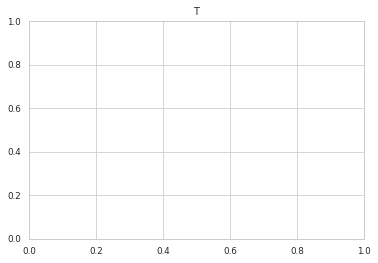

In [59]:
for cluster_label, cluster_ds in enumerate(clusters_ds):
    if cluster_label in plot_clusters:
        for var in timeseries_vars:
            plot_max_avg_duration(cluster_ds, var, thresholds[cluster_label], 'upwelling', upwelling_months)
            plt.title(var)

var O2
The average duration is  1.4223987867661545 And average max duration  6.402781475685491
var OmegaA
The average duration is  1.5164219327489927 And average max duration  5.597845620265754
var T
The average duration is  1.3962464637119254 And average max duration  6.884071717037867
var O2
The average duration is  1.4093354825554025 And average max duration  4.08793763278018
var OmegaA
The average duration is  1.720052178756496 And average max duration  5.838096402190737
var T
The average duration is  1.372038969849746 And average max duration  2.576907407289151


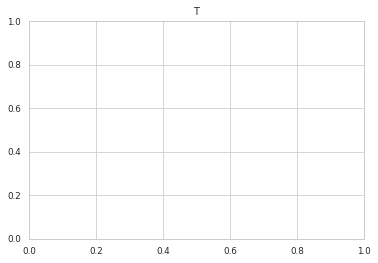

In [60]:
for cluster_label, cluster_ds in enumerate(clusters_ds):
    if cluster_label in plot_clusters:
        for var in timeseries_vars:
            plot_max_avg_duration(cluster_ds, var, thresholds[cluster_label], 'downwelling', downwelling_months)
            plt.title(var)

Intensity is defined here as the difference between the threshold and the observed value. For temperature ($T$) this is defined as

$I_T= T - T_{threshold}$

For $\Omega_A$ and $O_2$, the sign is reversed to maintain the convention that a positive intensity is considered an extreme event.

Annual cumulative intensity is defined as the sum of intensity and averaged over every point in the cluster. The average intensity is averaged both in time and over every point of the cluster

In [61]:
def plot_cumulative_intensity(cluster_ds, var, threshold, season, season_months):
    var_ds = cluster_ds[var]

    # Positive intensity implies an extreme event, negative is not
    if var == 'T':
        intensity = var_ds - threshold[season][var]
    else:
        intensity = threshold[season][var] - var_ds
        
    intensity = xr.where(intensity < 0, np.nan, intensity)
    intensity = xr.where(~intensity['time.month'].isin(season_months), np.nan, intensity)

    cumulative_intensity = intensity.groupby('time.year').sum(['time']).mean('stacked_y_x', skipna=True)
    average_intensity = intensity.groupby('time.year').mean(['time', 'stacked_y_x'], skipna=True)

    plt.subplot(1,2,1)
    plt.plot(cumulative_intensity.year, cumulative_intensity)
    plt.title(var)
    plt.subplot(1,2,2)
    plt.plot(cumulative_intensity.year, average_intensity)
    plt.tight_layout()
    


Cluster: 0
Cluster: 3


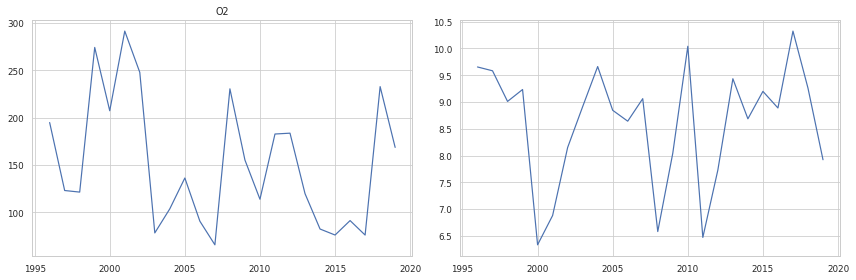

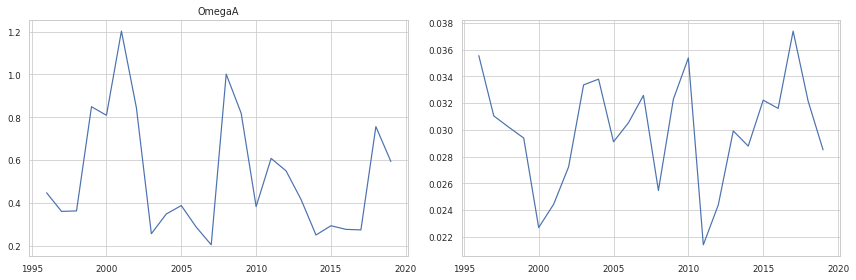

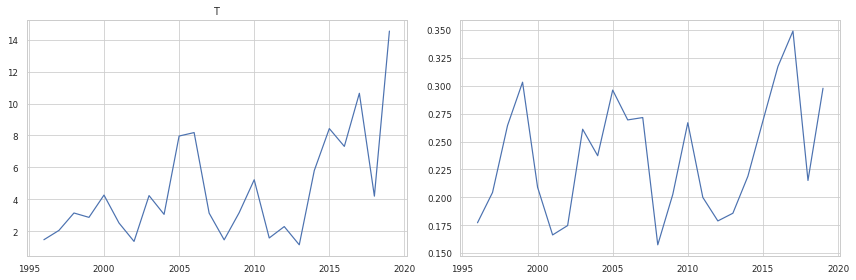

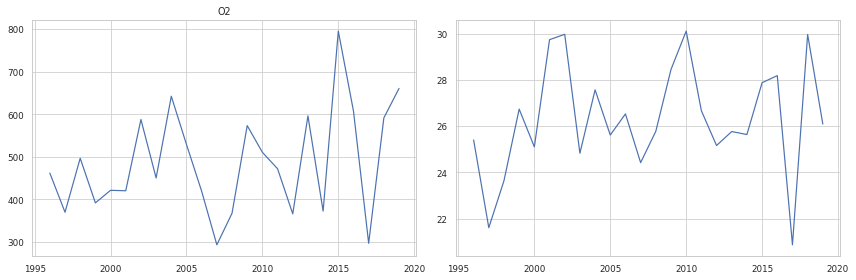

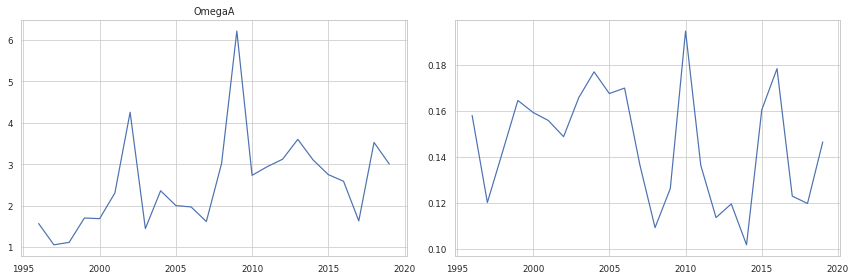

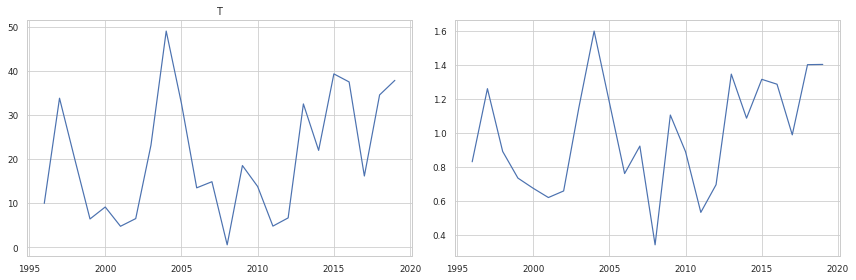

In [62]:
for cluster_label, cluster_ds in enumerate(clusters_ds):
    if cluster_label in plot_clusters:
        print(f"Cluster: {cluster_label}")
        for var in timeseries_vars:
            plt.figure(figsize=(12,4))
            plot_cumulative_intensity(cluster_ds, var, thresholds[cluster_label], 'upwelling', upwelling_months)

In [63]:
def calculate_max_severity(intensity):
    """
    Calculate the duration of the times when a point in the cluster is extreme, return the average extreme duration
    """

    intensity_str = ','.join([str(value) for value in intensity])
    
    # Split the string into runs of ones using the '0' character as a separator.
    ones_runs = intensity_str.split(',0.0,')

    run_severity = []
    # Calculate and store the length of each run of non_zeroes
    for run in ones_runs:
        values = np.asarray(run.split(','), dtype=float)
        run_severity.append(np.sum(values))

    if len(run_severity)>0:
        max_severity = np.max(run_severity)
        return np.array([max_severity])
    else:
        return np.array([0.])

def plot_max_severity(cluster_ds, var, threshold, season, season_months):
    var_ds = cluster_ds[var]
    if var == 'T':
        var_ds = var_ds - threshold[season][var]
    else:
        var_ds = threshold[season][var] - var_ds
    var_ds = var_ds.where(var_ds > 0, 0)
    var_ds = var_ds.where(cluster_ds['time.month'].isin(season_months), 0)
    max_duration = []
    avg_duration = []
    years = []
    
    for year, ds_year in var_ds.groupby('time.year'):
        lengths = xr.apply_ufunc(calculate_max_severity, ds_year.load(), input_core_dims = [['time']], vectorize=True)
        max_duration.append(lengths.max(dim='stacked_y_x'))
        avg_duration.append(lengths.mean(dim='stacked_y_x'))
        years.append(year) 
    plt.figure()
    plt.bar(years, max_duration)

calculate_max_severity(cluster_ds.isel(stacked_y_x=1000).T.values)

array([71734.201578])

In [64]:
test = ','.join([str(value) for value in cluster_ds.isel(stacked_y_x=1000).T.values])
np.array([float(value) for value in test.split('0.0')[0].split(',')])

array([8.137081 , 8.263342 , 8.38553  , 8.43153  , 8.471027 , 8.361212 ,
       8.398458 , 8.503199 , 8.597028 , 8.597329 , 8.408141 , 8.378941 ,
       8.524183 , 8.703125 , 8.886538 , 9.004857 , 8.572669 , 8.43831  ,
       8.4805975, 8.526677 , 8.6393   , 8.706204 , 8.835325 , 8.973462 ,
       9.08006  , 9.12548  , 9.117508 , 9.09673  , 9.077516 , 8.971177 ,
       8.953175 , 9.025416 , 9.047424 , 9.048371 , 8.974374 , 8.846759 ,
       8.773636 , 8.823975 , 8.8256855, 8.73923  , 8.661966 , 8.459183 ,
       8.308606 , 8.284258 , 8.288192 , 8.270132 , 8.273431 , 8.228023 ,
       8.192314 , 8.119995 , 8.354533 , 8.490789 , 8.55101  , 8.637221 ,
       8.59527  , 8.584818 , 8.614591 , 8.681984 , 8.719597 , 8.799929 ,
       8.804938 , 8.809356 , 8.815571 , 8.769789 , 8.684497 , 8.6584015,
       8.676357 , 8.796885 , 8.836225 , 8.794113 , 8.691338 , 8.74173  ,
       8.759546 , 8.763076 , 8.780799 , 8.695897 , 8.63075  , 8.596617 ,
       8.583045 , 8.653858 , 8.5827465, 8.474168 , 

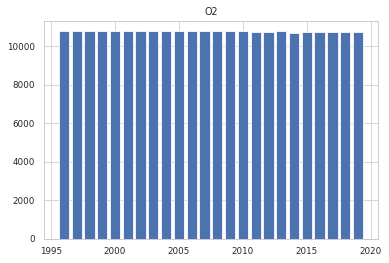

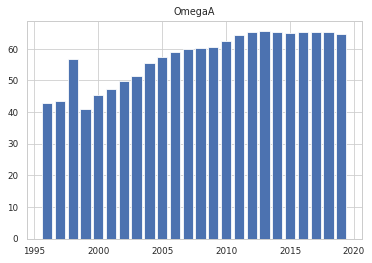

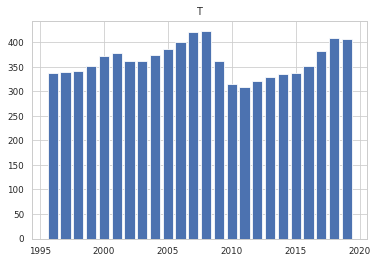

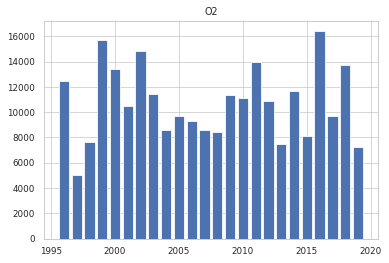

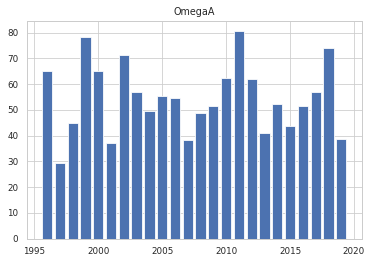

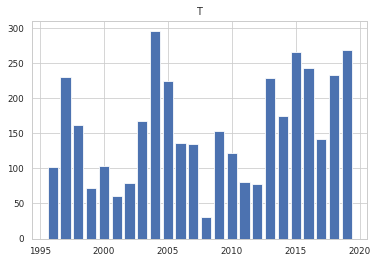

In [65]:
for cluster_label, cluster_ds in enumerate(clusters_ds):
    if cluster_label in plot_clusters:
        for var in timeseries_vars:
            plot_max_severity(cluster_ds, var, thresholds[cluster_label], 'upwelling', upwelling_months)
            plt.title(var)